In [0]:
from keras.datasets import cifar10

from keras.layers import Input
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import UpSampling2D
from keras.layers import Dense
from keras.layers import Dropout

from keras.models import Model

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from keras.utils import to_categorical

from keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

import numpy as np

# Data Preprocessing

In [0]:
#data load and separation
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#load_data automatically does 80/20 but needs 50/50
X = np.vstack((x_train,x_test))
y = np.vstack((y_train,y_test))

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=889, stratify=y)

In [0]:
#Image Augmentation
img_augm = ImageDataGenerator(
    width_shift_range=0.1, #horizontal shift
    height_shift_range=0.1,#vertical shift
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    data_format=None)

img_augm.fit(x_train)

In [33]:
#Data normalization
x_train = x_train.astype('float32')/255.
x_test = x_test.astype('float32')/255.
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (30000, 32, 32, 3)
x_test shape: (30000, 32, 32, 3)


In [0]:
#convert to matrices
num_classes = 10
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Autoencoder

In [0]:
#Encoder
img_input = Input(shape=(32, 32, 3))

layer = Conv2D(64, (3, 3), padding='same', activation='relu')(img_input)
layer = MaxPooling2D((2, 2), padding='same')(layer)

layer = Conv2D(128, (3, 3), padding='same',activation='relu')(layer)
encoded = MaxPooling2D((2, 2), padding='same')(layer)

#Decoder
layer = Conv2D(128, (3, 3), padding='same', activation='relu')(encoded)
layer = UpSampling2D((2, 2))(layer)

layer = Conv2D(64, (3, 3), padding='same',activation='relu')(layer)
layer = UpSampling2D((2, 2))(layer)

decoded = Conv2D(3, (3, 3), padding='same',activation='sigmoid')(layer)


In [36]:
autoencoder = Model(img_input, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')
autoencoder.summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
up_sampling2d_5 (UpSampling2 (None, 16, 16, 128)       0   

In [37]:
#Autoencoder training
autoencoder.fit_generator(
    img_augm.flow(x_train, x_train, batch_size=64),
    epochs=40,
    validation_data=(x_test, x_test),
    workers=8)

Epoch 1/40
469/469 [==============================] - 23s 49ms/step - loss: 0.6392 - val_loss: 0.5931
Epoch 2/40
469/469 [==============================] - 22s 48ms/step - loss: 0.6249 - val_loss: 0.5903
Epoch 3/40
469/469 [==============================] - 22s 47ms/step - loss: 0.6224 - val_loss: 0.5912
Epoch 4/40
469/469 [==============================] - 22s 46ms/step - loss: 0.6212 - val_loss: 0.5911
Epoch 5/40
469/469 [==============================] - 23s 48ms/step - loss: 0.6204 - val_loss: 0.5904
Epoch 6/40
469/469 [==============================] - 22s 47ms/step - loss: 0.6202 - val_loss: 0.5903
Epoch 7/40
469/469 [==============================] - 22s 48ms/step - loss: 0.6196 - val_loss: 0.5904
Epoch 8/40
469/469 [==============================] - 22s 46ms/step - loss: 0.6193 - val_loss: 0.5874
Epoch 9/40
469/469 [==============================] - 22s 46ms/step - loss: 0.6189 - val_loss: 0.5883
Epoch 10/40
469/469 [==============================] - 22s 48ms/step - loss: 0.619

In [0]:
#Save and Load (if needed)
autoencoder.save_weights('autoenc.h5')

In [0]:
autoencoder.load_weights('autoenc.h5')

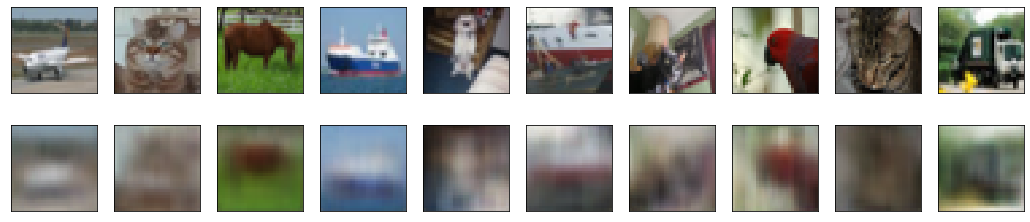

In [40]:
#original VS rebuilt images (code from Keras documentation)

decoded_imgs = autoencoder.predict(x_test)

n = 11
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs[i].reshape(32,32,3))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

# Convolutional Neural Network

In [0]:
layer = Conv2D(64, (3, 3), padding='same', activation='relu')(encoded)
layer = MaxPooling2D((2, 2), padding='same')(layer)
layer = Dropout(0.15)(layer)

#layer = Conv2D(32, (3, 3), padding='same', activation='relu')(layer)
#layer = MaxPooling2D((2, 2), padding='same')(layer)

layer = Flatten()(layer)

layer = Dense(256, activation='relu')(layer)
layer = Dropout(0.05)(layer)

cnn_output = Dense(10, activation='softmax')(layer)

In [0]:
classifier = Model(img_input, cnn_output)

In [0]:
#Freeze the Encoder layers (no weights update possible)
for layer in classifier.layers[0:5]:
    layer.trainable = False

In [44]:
classifier.compile(optimizer='adadelta',loss='categorical_crossentropy',metrics=['accuracy'])
classifier.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 8, 8, 64)          73792     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 4, 4, 64)          0   

In [45]:
#Autoencoder_CNN Training

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=20) #stop training if no progress
checkpoint = ModelCheckpoint('autoenc_cnn.h5', monitor='val_loss', mode='min', save_best_only=True) #save lowest loss

history = classifier.fit_generator(
    img_augm.flow(x_train, y_train, batch_size=64),
    epochs=50,
    class_weight={0:1, 1:1, 2:1.9, 3:2.5, 4:1.8, 5:2.5, 6:1, 7:1, 8:1, 9:1}, #gives importance to some classes
    validation_data=(x_test, y_test),
    workers=8,
    callbacks=[early_stop, checkpoint]
    )

Epoch 1/50
469/469 [==============================] - 22s 46ms/step - loss: 2.4028 - acc: 0.3858 - val_loss: 1.3989 - val_acc: 0.4884
Epoch 2/50
469/469 [==============================] - 21s 46ms/step - loss: 2.0401 - acc: 0.4975 - val_loss: 1.2139 - val_acc: 0.5687
Epoch 3/50
469/469 [==============================] - 21s 45ms/step - loss: 1.9029 - acc: 0.5353 - val_loss: 1.2173 - val_acc: 0.5612
Epoch 4/50
469/469 [==============================] - 21s 44ms/step - loss: 1.8034 - acc: 0.5620 - val_loss: 1.0780 - val_acc: 0.6177
Epoch 5/50
469/469 [==============================] - 21s 44ms/step - loss: 1.7417 - acc: 0.5802 - val_loss: 1.0739 - val_acc: 0.6170
Epoch 6/50
469/469 [==============================] - 21s 44ms/step - loss: 1.6725 - acc: 0.5964 - val_loss: 1.0252 - val_acc: 0.6383
Epoch 7/50
469/469 [==============================] - 20s 43ms/step - loss: 1.6344 - acc: 0.6071 - val_loss: 0.9970 - val_acc: 0.6488
Epoch 8/50
469/469 [==============================] - 20s 43ms

# Results & Metrics

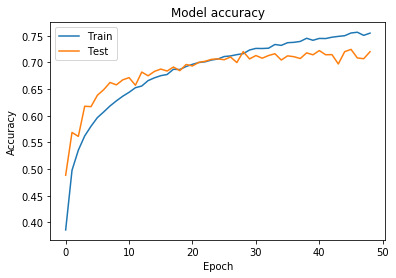

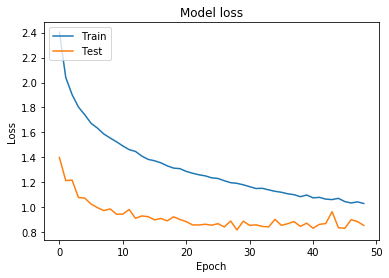

In [46]:
#Accuracy and Loss (code from Keras documentation)

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
#load best classifier
classifier.load_weights('autoenc_cnn.h5')

In [48]:
#score (loss and accuracy)
classifier.evaluate(x_test, y_test, verbose=0)

[0.8186194316864014, 0.7202666666666667]

In [0]:
pred = classifier.predict(x_test)

y_true = np.argmax(y_test, axis=1)
prediction = np.argmax(pred, axis=1)

In [50]:
confusion_matrix(y_true, prediction)

array([[2020,   86,  234,   87,   60,   47,   36,   49,  178,  203],
       [  37, 2417,   13,   21,    7,    5,   22,    8,   50,  420],
       [  94,   22, 1937,  171,  273,  157,  202,   64,   38,   42],
       [  27,   37,  197, 1689,  181,  444,  183,   96,   43,  103],
       [  46,   12,  202,  154, 2093,   67,  165,  200,   24,   37],
       [  11,   21,  147,  464,  169, 1857,   86,  157,   23,   65],
       [  11,   28,  136,  182,  123,   53, 2384,   18,   14,   51],
       [  27,   20,  104,  123,  222,  136,   21, 2232,   14,  101],
       [ 153,  116,   41,   48,   20,   16,   11,    8, 2414,  173],
       [  40,  223,   19,   35,    6,   10,   34,   24,   44, 2565]])

In [51]:
#Metrics for each class
print(classification_report(y_true, prediction, [0,1,2,3,4,5,6,7,8,9]))

              precision    recall  f1-score   support

           0       0.82      0.67      0.74      3000
           1       0.81      0.81      0.81      3000
           2       0.64      0.65      0.64      3000
           3       0.57      0.56      0.57      3000
           4       0.66      0.70      0.68      3000
           5       0.67      0.62      0.64      3000
           6       0.76      0.79      0.78      3000
           7       0.78      0.74      0.76      3000
           8       0.85      0.80      0.83      3000
           9       0.68      0.85      0.76      3000

    accuracy                           0.72     30000
   macro avg       0.72      0.72      0.72     30000
weighted avg       0.72      0.72      0.72     30000

